# [모의 캐글-의료] 흉부 CT 코로나 감염 여부 분류
- 이미지 binary 분류 과제
- 담당: 이녕민M

## Import Libraries

In [ ]:
!apt-get update && apt-get install -y python3-opencv

In [ ]:
!pip install sklearn

In [1]:
import os, torch, copy, cv2, sys, random
# from datetime import datetime, timezone, timedelta
from PIL import Image
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms

## Set Arguments & hyperparameters

In [2]:
# 시드(seed) 설정

RANDOM_SEED = 2022

torch.manual_seed(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

In [50]:
# parameters

### 데이터 디렉토리 설정 ###
DATA_DIR= 'data'
NUM_CLS = 2

EPOCHS = 30
BATCH_SIZE = 32
LEARNING_RATE = 0.0005
EARLY_STOPPING_PATIENCE = 20
INPUT_SHAPE = 128

os.environ["CUDA_VISIBLE_DEVICES"]="0"
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [76]:
DEVICE

device(type='cuda')

## Dataloader

#### Train & Validation Set loader

In [5]:
class CustomDataset(Dataset):
    def __init__(self, data_dir, mode, input_shape):
        self.data_dir = data_dir
        self.mode = mode
        self.input_shape = input_shape
        
        # Loading dataset
        self.db = self.data_loader()
        
        # Dataset split
        if self.mode == 'train':
            self.db = self.db[:int(len(self.db) * 0.9)]
        elif self.mode == 'val':
            self.db = self.db[int(len(self.db) * 0.9):]
            self.db.reset_index(inplace=True)
        else:
            print(f'!!! Invalid split {self.mode}... !!!')
            
        # Transform function
        self.transform = transforms.Compose([transforms.Resize(self.input_shape),
                                             transforms.ToTensor(),
                                             transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

    def data_loader(self):
        print('Loading ' + self.mode + ' dataset..')
        if not os.path.isdir(self.data_dir):
            print(f'!!! Cannot find {self.data_dir}... !!!')
            sys.exit()
        
        # (COVID : 1, No : 0)
        db = pd.read_csv(os.path.join(self.data_dir, 'train.csv'))
        
        return db

    def __len__(self):
        return len(self.db)

    def __getitem__(self, index):
        data = copy.deepcopy(self.db.loc[index])

        # Loading image
        cvimg = cv2.imread(os.path.join(self.data_dir,'train',data['file_name']), cv2.IMREAD_COLOR | cv2.IMREAD_IGNORE_ORIENTATION)
        if not isinstance(cvimg, np.ndarray):
            raise IOError("Fail to read %s" % data['file_name'])

        # Preprocessing images
        trans_image = self.transform(Image.fromarray(cvimg))

        return trans_image, data['COVID']


## Model

In [6]:
import torch.nn.functional as F

class custom_CNN(nn.Module):
    def __init__(self, num_classes):
        super(custom_CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=25, kernel_size=5)
        
        self.fc1 = nn.Linear(in_features=25*29*29, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=num_classes)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) # (32, 3, 128, 128) -> (32, 8, 62, 62)
        x = self.pool(F.relu(self.conv2(x))) # (32, 8, 62, 62) -> (32, 25, 29, 29)
        
        x = torch.flatten(x,1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        
        output = self.softmax(x)
        
        return output

In [19]:
!pip install efficientnet-pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16445 sha256=c848f548245284f73ed9b8b3c17381a783a2ecb617c8a2af305b4e37db677282
  Stored in directory: /root/.cache/pip/wheels/84/b9/90/25a0195cf95fb5533db96f1c77ea3f296b7cc86ae8ae48e3dc
Successfully built efficientnet-pytorch


## Utils
### EarlyStopper

In [7]:
class LossEarlyStopper():
    """Early stopper
    
    Attributes:
        patience (int): loss가 줄어들지 않아도 학습할 epoch 수
        patience_counter (int): loss 가 줄어들지 않을 때 마다 1씩 증가, 감소 시 0으로 리셋
        min_loss (float): 최소 loss
        stop (bool): True 일 때 학습 중단

    """

    def __init__(self, patience: int)-> None:
        self.patience = patience

        self.patience_counter = 0
        self.min_loss = np.Inf
        self.stop = False
        self.save_model = False

    def check_early_stopping(self, loss: float)-> None:
        """Early stopping 여부 판단"""  

        if self.min_loss == np.Inf:
            self.min_loss = loss
            return None

        elif loss > self.min_loss:
            self.patience_counter += 1
            msg = f"Early stopping counter {self.patience_counter}/{self.patience}"

            if self.patience_counter == self.patience:
                self.stop = True
                
        elif loss <= self.min_loss:
            self.patience_counter = 0
            self.save_model = True
            msg = f"Validation loss decreased {self.min_loss} -> {loss}"
            self.min_loss = loss
        
        print(msg)

### Trainer

In [8]:
class Trainer():
    """ epoch에 대한 학습 및 검증 절차 정의"""
    
    def __init__(self, loss_fn, model, device, metric_fn, optimizer=None, scheduler=None):
        """ 초기화
        """
        self.loss_fn = loss_fn
        self.model = model
        self.device = device
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.metric_fn = metric_fn

    def train_epoch(self, dataloader, epoch_index):
        """ 한 epoch에서 수행되는 학습 절차"""
        
        self.model.train()
        train_total_loss = 0
        target_lst = []
        pred_lst = []
        prob_lst = []

        for batch_index, (img, label) in enumerate(dataloader):
            img = img.to(self.device)
            label = label.to(self.device).float()
            
            pred = self.model(img)
            
            loss = self.loss_fn(pred[:,1], label)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            self.scheduler.step()
            
            train_total_loss += loss.item()
            prob_lst.extend(pred[:, 1].cpu().tolist())
            target_lst.extend(label.cpu().tolist())
            pred_lst.extend(pred.argmax(dim=1).cpu().tolist())
        self.train_mean_loss = train_total_loss / batch_index
        self.train_score, f1 = self.metric_fn(y_pred=pred_lst, y_answer=target_lst)
        msg = f'Epoch {epoch_index}, Train loss: {self.train_mean_loss}, Acc: {self.train_score}, F1-Macro: {f1}'
        print(msg)

    def validate_epoch(self, dataloader, epoch_index):
        """ 한 epoch에서 수행되는 검증 절차
        """
        self.model.eval()
        val_total_loss = 0
        target_lst = []
        pred_lst = []
        prob_lst = []

        for batch_index, (img, label) in enumerate(dataloader):
            img = img.to(self.device)
            label = label.to(self.device).float()
            pred = self.model(img)
            
            loss = self.loss_fn(pred[:,1], label)
            val_total_loss += loss.item()
            prob_lst.extend(pred[:, 1].cpu().tolist())
            target_lst.extend(label.cpu().tolist())
            pred_lst.extend(pred.argmax(dim=1).cpu().tolist())
        self.val_mean_loss = val_total_loss / batch_index
        self.validation_score, f1 = self.metric_fn(y_pred=pred_lst, y_answer=target_lst)
        msg = f'Epoch {epoch_index}, Val loss: {self.val_mean_loss}, Acc: {self.validation_score}, F1-Macro: {f1}'
        print(msg)

### Metrics

In [9]:
from sklearn.metrics import accuracy_score, f1_score

def get_metric_fn(y_pred, y_answer):
    """ 성능을 반환하는 함수"""
    
    assert len(y_pred) == len(y_answer), 'The size of prediction and answer are not same.'
    accuracy = accuracy_score(y_answer, y_pred)
    f1 = f1_score(y_answer, y_pred, average='macro')
    return accuracy, f1

## Train
### 학습을 위한 객체 선언

#### Load Dataset & Dataloader

In [10]:
# Load dataset & dataloader
train_dataset = CustomDataset(data_dir=DATA_DIR, mode='train', input_shape=INPUT_SHAPE)
validation_dataset = CustomDataset(data_dir=DATA_DIR, mode='val', input_shape=INPUT_SHAPE)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=True)
print('Train set samples:',len(train_dataset),  'Val set samples:', len(validation_dataset))

Loading train dataset..
Loading val dataset..
Train set samples: 581 Val set samples: 65


#### data check

In [14]:
def show_image(image,label,get_denormalize = True):
    
    image = image.permute(1,2,0)
    mean = torch.FloatTensor([0.485, 0.456, 0.406])
    std = torch.FloatTensor([0.229, 0.224, 0.225])
    
    if get_denormalize == True:
        image = image*std + mean
        image = np.clip(image,0,1)
        plt.imshow(image)
        plt.title(label)
        
    else: 
        plt.imshow(image)
        plt.title(label)

def show_grid(image,title = None):
    
    image = image.permute(1,2,0)
    mean = torch.FloatTensor([0.485, 0.456, 0.406])
    std = torch.FloatTensor([0.229, 0.224, 0.225])
    
    image = image*std + mean
    image = np.clip(image,0,1)
    
    plt.figure(figsize=[15, 15])
    plt.imshow(image)
    if title != None:
        plt.title(title)

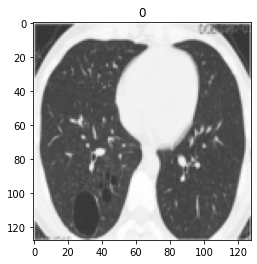

In [15]:
import matplotlib.pyplot as plt 

img, label = train_dataset[0]
show_image(img, label)

In [27]:
img.shape

torch.Size([3, 128, 128])

In [16]:
class_name = [1, 0]

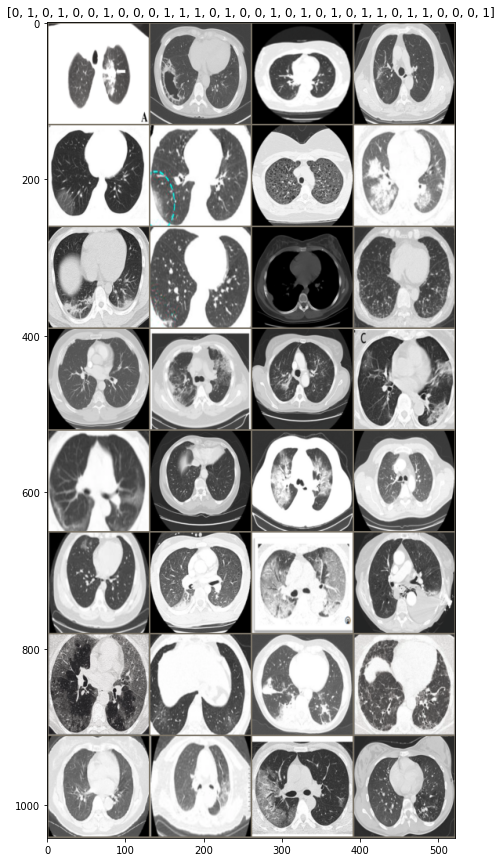

In [17]:
from torchvision.utils import make_grid
dataiter = iter(train_dataloader)
images,labels = dataiter.next()

out = make_grid(images,nrow=4)

show_grid(out,title = [class_name[x] for x in labels])

#### 새로운 모델

In [6]:
from efficientnet_pytorch import EfficientNet

class effnet(nn.Module):
    def __init__(self, num_classes):
        super(effnet, self).__init__()
        self.model = EfficientNet.from_name('efficientnet-b4', num_classes=2)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.model(x)
        x = self.softmax(x)
        
        return x

In [12]:
from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_name('efficientnet-b4', num_classes=2)
model

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        48, 12, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        12, 48, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        48, 24, kernel_siz

In [11]:
effnet_= effnet(2)

In [19]:
import timm
import torch

# timm 에서  상
avail_models = timm.list_models(pretrained=False)
avail_models

['adv_inception_v3',
 'bat_resnext26ts',
 'beit_base_patch16_224',
 'beit_base_patch16_224_in22k',
 'beit_base_patch16_384',
 'beit_large_patch16_224',
 'beit_large_patch16_224_in22k',
 'beit_large_patch16_384',
 'beit_large_patch16_512',
 'botnet26t_256',
 'botnet50ts_256',
 'cait_m36_384',
 'cait_m48_448',
 'cait_s24_224',
 'cait_s24_384',
 'cait_s36_384',
 'cait_xs24_384',
 'cait_xxs24_224',
 'cait_xxs24_384',
 'cait_xxs36_224',
 'cait_xxs36_384',
 'coat_lite_mini',
 'coat_lite_small',
 'coat_lite_tiny',
 'coat_mini',
 'coat_tiny',
 'convit_base',
 'convit_small',
 'convit_tiny',
 'convmixer_768_32',
 'convmixer_1024_20_ks9_p14',
 'convmixer_1536_20',
 'convnext_base',
 'convnext_base_384_in22ft1k',
 'convnext_base_in22ft1k',
 'convnext_base_in22k',
 'convnext_large',
 'convnext_large_384_in22ft1k',
 'convnext_large_in22ft1k',
 'convnext_large_in22k',
 'convnext_small',
 'convnext_tiny',
 'convnext_tiny_hnf',
 'convnext_xlarge_384_in22ft1k',
 'convnext_xlarge_in22ft1k',
 'convnext_x

In [26]:
#timm conv -> cuda error

from torch import nn
import torch.nn.functional as F
import timm

efficientnet_b4 = timm.create_model('efficientnet_b4', pretrained = False, num_classes = 2)

efficientnet_b4

EfficientNet(
  (conv_stem): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): SiLU(inplace=True)
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
        (bn1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): SiLU(inplace=True)
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(48, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act2): Identity()
 

In [27]:
efficientnet_b4.classifier = nn.Sequential(
    nn.Linear(in_features=1792, out_features=625), #1792 is the orginal in_features
    nn.ReLU(), #ReLu to be the activation function
    nn.Dropout(p=0.3),
    nn.Linear(in_features=625, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=2), 
    nn.Softmax(dim=1)
)

In [28]:
efficientnet_b4

EfficientNet(
  (conv_stem): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): SiLU(inplace=True)
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
        (bn1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): SiLU(inplace=True)
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(48, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act2): Identity()
 

In [40]:
efficient_b0 = timm.create_model('efficientnet_b0', pretrained = False, num_classes = 2)


class effnet_b0(nn.Module):
    def __init__(self, num_classes=2):
        super(effnet_b0, self).__init__()
        self.model = timm.create_model('efficientnet_b0', pretrained = False, num_classes = num_classes)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.model(x)
        x = self.softmax(x)
        
        return x

In [87]:
effnet_b0()

effnet_b0(
  (model): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): SiLU(inplace=True)
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act1): SiLU(inplace=True)
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, 

In [91]:
import torchvision.models as models

class resnet(nn.Module):
    def __init__(self, num_classes =2):
        super(resnet, self).__init__()
        self.model = models.resnet18(num_classes = num_classes)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.model(x)
        x = self.softmax(x)
        
        return x

In [92]:
resnet()

resnet(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runnin

In [103]:
from torchvision.models import GoogLeNet

class google_net(nn.Module):
    def __init__ (self, num_classes = 2):
        super(google_net, self).__init__()
        self.model = models.googlenet(num_classes = num_classes)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        
        x = self.model(x)
        if isinstance(x, torch.Tensor):
            pass
        else:
            x = x.logits
        
        x = self.softmax(x)
        
        return x

In [100]:
model = google_net()
x = torch.randn(3,3,128,128)
model(x)

tensor([[0.4773, 0.5227],
        [0.4942, 0.5058],
        [0.4708, 0.5292]], grad_fn=<SoftmaxBackward>)

In [104]:
from torchsummary import  summary
google_net.to(DEVICE) # move the model to GPU
summary(google_net ,input_size=(3,128,128))

AttributeError: 'torch.device' object has no attribute '_apply'

#### Load model and other utils

In [77]:
# Load Model
# model = custom_CNN(NUM_CLS).to(DEVICE)
# model = efficientnet_b4.to(DEVICE) -> early stopping
# model = effnet_.to(DEVICE) -> 제대로 학습이 이루어 지지 않음 (efficientnet_pytorch import EfficientNet)
# model = resnet.to(DEVICE) -> 제대로 학습이 이루어 지지 않음
model = effnet_b0().to(DEVICE)
# model = google_net().to(DEVICE)

# # Save Initial Model
# torch.save(model.state_dict(), 'initial.pt')

# Set optimizer, scheduler, loss function, metric function
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler =  optim.lr_scheduler.OneCycleLR(optimizer=optimizer, pct_start=0.1, div_factor=1e5, max_lr=0.0001, epochs=EPOCHS, steps_per_epoch=len(train_dataloader))
loss_fn = nn.BCELoss()
metric_fn = get_metric_fn


# Set trainer
trainer = Trainer(loss_fn, model, DEVICE, metric_fn, optimizer, scheduler)

# Set earlystopper
early_stopper = LossEarlyStopper(patience=EARLY_STOPPING_PATIENCE)

In [78]:
model

google_net(
  (model): GoogLeNet(
    (conv1): BasicConv2d(
      (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (conv2): BasicConv2d(
      (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv3): BasicConv2d(
      (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (inception3a): Inception(
      (branch1): BasicConv2d(
        (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): 

### epoch 단위 학습 진행

In [18]:
# model = effnet_ 학습진행 (torch.vision EfficientNet)

for epoch_index in tqdm(range(EPOCHS)):

    trainer.train_epoch(train_dataloader, epoch_index)
    trainer.validate_epoch(validation_dataloader, epoch_index)

    # early_stopping check
    early_stopper.check_early_stopping(loss=trainer.val_mean_loss)

    if early_stopper.stop:
        print('Early stopped')
        break

    if early_stopper.save_model:
        check_point = {
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'scheduler': scheduler.state_dict()
        }
        torch.save(check_point, 'best.pt')


  0% 0/30 [00:00<?, ?it/s]

Epoch 0, Train loss: 0.7313849230607351, Acc: 0.5989672977624785, F1-Macro: 0.5908166257099419
Epoch 0, Val loss: 1.0369346737861633, Acc: 0.49230769230769234, F1-Macro: 0.32989690721649484
Validation loss decreased 1.0406757295131683 -> 1.0369346737861633


  3% 1/30 [00:56<27:27, 56.81s/it]

Epoch 1, Train loss: 0.7636805044280158, Acc: 0.5817555938037866, F1-Macro: 0.567354631119283
Epoch 1, Val loss: 1.0410989224910736, Acc: 0.5076923076923077, F1-Macro: 0.336734693877551
Early stopping counter 1/10


  7% 2/30 [02:02<27:44, 59.46s/it]

Epoch 2, Train loss: 0.7303363349702623, Acc: 0.5886402753872634, F1-Macro: 0.5855709855817299
Epoch 2, Val loss: 1.0378089547157288, Acc: 0.5076923076923077, F1-Macro: 0.336734693877551
Early stopping counter 2/10


 10% 3/30 [03:09<27:50, 61.86s/it]

Epoch 3, Train loss: 0.7197698553403219, Acc: 0.6092943201376936, F1-Macro: 0.606829733637407
Epoch 3, Val loss: 1.0509045124053955, Acc: 0.49230769230769234, F1-Macro: 0.32989690721649484
Early stopping counter 3/10


 13% 4/30 [04:17<27:35, 63.65s/it]

Epoch 4, Train loss: 0.6529949506123861, Acc: 0.6678141135972461, F1-Macro: 0.6596471206000103
Epoch 4, Val loss: 1.0234166085720062, Acc: 0.49230769230769234, F1-Macro: 0.32989690721649484
Validation loss decreased 1.0369346737861633 -> 1.0234166085720062


 17% 5/30 [05:14<25:39, 61.57s/it]

Epoch 5, Train loss: 0.5445484701130126, Acc: 0.7555938037865749, F1-Macro: 0.749987878494024
Epoch 5, Val loss: 1.020626276731491, Acc: 0.49230769230769234, F1-Macro: 0.32989690721649484
Validation loss decreased 1.0234166085720062 -> 1.020626276731491


 20% 6/30 [06:06<23:31, 58.80s/it]

Epoch 6, Train loss: 0.5074017660485374, Acc: 0.7814113597246127, F1-Macro: 0.7769687187346034
Epoch 6, Val loss: 1.0209211707115173, Acc: 0.49230769230769234, F1-Macro: 0.32989690721649484
Early stopping counter 1/10


 23% 7/30 [06:54<21:12, 55.32s/it]

Epoch 7, Train loss: 0.46860774689250523, Acc: 0.8072289156626506, F1-Macro: 0.8041368682125744
Epoch 7, Val loss: 1.0768300294876099, Acc: 0.49230769230769234, F1-Macro: 0.32989690721649484
Early stopping counter 2/10


 27% 8/30 [07:44<19:42, 53.75s/it]

Epoch 8, Train loss: 0.35682058582703274, Acc: 0.8588640275387264, F1-Macro: 0.8577680917124433
Epoch 8, Val loss: 1.0009531378746033, Acc: 0.49230769230769234, F1-Macro: 0.32989690721649484
Validation loss decreased 1.020626276731491 -> 1.0009531378746033


 30% 9/30 [08:38<18:52, 53.95s/it]

Epoch 9, Train loss: 0.3336871133910285, Acc: 0.8502581755593803, F1-Macro: 0.8495450364774482
Epoch 9, Val loss: 1.0034944713115692, Acc: 0.49230769230769234, F1-Macro: 0.32989690721649484
Early stopping counter 1/10


 33% 10/30 [09:32<17:58, 53.93s/it]

Epoch 10, Train loss: 0.3212529346346855, Acc: 0.8864027538726333, F1-Macro: 0.8853755649616186
Epoch 10, Val loss: 0.9922073483467102, Acc: 0.49230769230769234, F1-Macro: 0.32989690721649484
Validation loss decreased 1.0009531378746033 -> 0.9922073483467102


 37% 11/30 [10:25<17:01, 53.78s/it]

Epoch 11, Train loss: 0.3266361964245637, Acc: 0.8623063683304647, F1-Macro: 0.8599730068446929
Epoch 11, Val loss: 0.9721625447273254, Acc: 0.49230769230769234, F1-Macro: 0.32989690721649484
Validation loss decreased 0.9922073483467102 -> 0.9721625447273254


 40% 12/30 [11:18<16:04, 53.60s/it]

Epoch 12, Train loss: 0.22759617368380228, Acc: 0.9242685025817556, F1-Macro: 0.9236330178759201
Epoch 12, Val loss: 0.9654591828584671, Acc: 0.49230769230769234, F1-Macro: 0.32989690721649484
Validation loss decreased 0.9721625447273254 -> 0.9654591828584671


 43% 13/30 [12:16<15:31, 54.82s/it]

Epoch 13, Train loss: 0.22525001193086305, Acc: 0.9259896729776248, F1-Macro: 0.925817380640602
Epoch 13, Val loss: 0.9652143269777298, Acc: 0.49230769230769234, F1-Macro: 0.32989690721649484
Validation loss decreased 0.9654591828584671 -> 0.9652143269777298


 47% 14/30 [13:13<14:44, 55.30s/it]

Epoch 14, Train loss: 0.20040848447630802, Acc: 0.9242685025817556, F1-Macro: 0.9236804394554573
Epoch 14, Val loss: 0.9651559442281723, Acc: 0.49230769230769234, F1-Macro: 0.32989690721649484
Validation loss decreased 0.9652143269777298 -> 0.9651559442281723


 50% 15/30 [14:20<14:45, 59.02s/it]

Epoch 15, Train loss: 0.16039128580855, Acc: 0.9380378657487092, F1-Macro: 0.9377855511136493
Epoch 15, Val loss: 1.2950832843780518, Acc: 0.49230769230769234, F1-Macro: 0.32989690721649484
Early stopping counter 1/10


 53% 16/30 [15:22<13:56, 59.77s/it]

Epoch 16, Train loss: 0.1746477314995395, Acc: 0.9242685025817556, F1-Macro: 0.9237259816207184
Epoch 16, Val loss: 1.3105600476264954, Acc: 0.49230769230769234, F1-Macro: 0.32989690721649484
Early stopping counter 2/10


 57% 17/30 [16:31<13:34, 62.63s/it]

Epoch 17, Train loss: 0.17228973822461235, Acc: 0.9414802065404475, F1-Macro: 0.9412419093851132
Epoch 17, Val loss: 1.4512828588485718, Acc: 0.49230769230769234, F1-Macro: 0.32989690721649484
Early stopping counter 3/10


 60% 18/30 [17:31<12:22, 61.89s/it]

Epoch 18, Train loss: 0.2015942761467563, Acc: 0.9397590361445783, F1-Macro: 0.9395268612552601
Epoch 18, Val loss: 0.9675796329975128, Acc: 0.49230769230769234, F1-Macro: 0.32989690721649484
Early stopping counter 4/10


 63% 19/30 [18:30<11:09, 60.82s/it]

Epoch 19, Train loss: 0.14285420253872871, Acc: 0.9518072289156626, F1-Macro: 0.9514897779050073
Epoch 19, Val loss: 1.0316853523254395, Acc: 0.49230769230769234, F1-Macro: 0.32989690721649484
Early stopping counter 5/10


 67% 20/30 [19:37<10:28, 62.85s/it]

Epoch 20, Train loss: 0.17026356462803152, Acc: 0.9535283993115319, F1-Macro: 0.953235254661718
Epoch 20, Val loss: 1.5805572867393494, Acc: 0.49230769230769234, F1-Macro: 0.32989690721649484
Early stopping counter 6/10


 70% 21/30 [20:41<09:27, 63.10s/it]

Epoch 21, Train loss: 0.25332856240371865, Acc: 0.9345955249569707, F1-Macro: 0.9342352969211705
Epoch 21, Val loss: 0.8993780463933945, Acc: 0.49230769230769234, F1-Macro: 0.32989690721649484
Validation loss decreased 0.9651559442281723 -> 0.8993780463933945


 73% 22/30 [21:44<08:26, 63.26s/it]

Epoch 22, Train loss: 0.11734843026432726, Acc: 0.9655765920826161, F1-Macro: 0.9653498413607194
Epoch 22, Val loss: 1.0560198277235031, Acc: 0.49230769230769234, F1-Macro: 0.32989690721649484
Early stopping counter 1/10


 77% 23/30 [22:37<06:59, 59.92s/it]

Epoch 23, Train loss: 0.12319112279348904, Acc: 0.9569707401032702, F1-Macro: 0.9566496846842814
Epoch 23, Val loss: 1.764195293188095, Acc: 0.49230769230769234, F1-Macro: 0.32989690721649484
Early stopping counter 2/10


 80% 24/30 [23:25<05:37, 56.33s/it]

Epoch 24, Train loss: 0.13871190779738957, Acc: 0.9414802065404475, F1-Macro: 0.9411270325687855
Epoch 24, Val loss: 0.9435827359557152, Acc: 0.49230769230769234, F1-Macro: 0.32989690721649484
Early stopping counter 3/10


 83% 25/30 [24:14<04:30, 54.20s/it]

Epoch 25, Train loss: 0.12270987716813882, Acc: 0.963855421686747, F1-Macro: 0.9636655479352109
Epoch 25, Val loss: 1.8961109220981598, Acc: 0.5076923076923077, F1-Macro: 0.3627450980392157
Early stopping counter 4/10


 87% 26/30 [25:01<03:28, 52.10s/it]

Epoch 26, Train loss: 0.18528052978217602, Acc: 0.9569707401032702, F1-Macro: 0.9567658150797265
Epoch 26, Val loss: 1.0556446313858032, Acc: 0.5538461538461539, F1-Macro: 0.45219412961348443
Early stopping counter 5/10


 90% 27/30 [25:51<02:34, 51.38s/it]

Epoch 27, Train loss: 0.11431703354335493, Acc: 0.9621342512908778, F1-Macro: 0.9619800590138969
Epoch 27, Val loss: 1.745754063129425, Acc: 0.5692307692307692, F1-Macro: 0.49444444444444446
Early stopping counter 6/10


 93% 28/30 [26:50<01:55, 57.52s/it]


ValueError: Tried to step 572 times. The specified number of total steps is 570

In [24]:
# resnet 학습 -> early stopping

for epoch_index in tqdm(range(EPOCHS)):

    trainer.train_epoch(train_dataloader, epoch_index)
    trainer.validate_epoch(validation_dataloader, epoch_index)

    # early_stopping check
    early_stopper.check_early_stopping(loss=trainer.val_mean_loss)

    if early_stopper.stop:
        print('Early stopped')
        break

    if early_stopper.save_model:
        check_point = {
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'scheduler': scheduler.state_dict()
        }
        torch.save(check_point, 'best.pt')

  0% 0/30 [00:00<?, ?it/s]

Epoch 0, Train loss: 0.7210309935940636, Acc: 0.5593803786574871, F1-Macro: 0.5318055905313523


  3% 1/30 [00:54<26:25, 54.68s/it]

Epoch 0, Val loss: 1.0558726489543915, Acc: 0.5846153846153846, F1-Macro: 0.5190463140586462
Epoch 1, Train loss: 0.5754546092616187, Acc: 0.7590361445783133, F1-Macro: 0.7553831348490316
Epoch 1, Val loss: 0.8795858025550842, Acc: 0.6153846153846154, F1-Macro: 0.554672513017265
Validation loss decreased 1.0558726489543915 -> 0.8795858025550842


  7% 2/30 [01:49<25:35, 54.84s/it]

Epoch 2, Train loss: 0.32209425750705933, Acc: 0.8950086058519794, F1-Macro: 0.8940240711669283
Epoch 2, Val loss: 0.7212294489145279, Acc: 0.7384615384615385, F1-Macro: 0.7215923406399596
Validation loss decreased 0.8795858025550842 -> 0.7212294489145279


 10% 3/30 [02:46<24:51, 55.26s/it]

Epoch 3, Train loss: 0.07015160450504886, Acc: 0.9879518072289156, F1-Macro: 0.9879000467099255
Epoch 3, Val loss: 1.6904044563416392, Acc: 0.5230769230769231, F1-Macro: 0.39398496240601505
Early stopping counter 1/10


 13% 4/30 [03:48<24:55, 57.53s/it]

Epoch 4, Train loss: 0.01763121268918945, Acc: 1.0, F1-Macro: 1.0
Epoch 4, Val loss: 1.1018466353416443, Acc: 0.676923076923077, F1-Macro: 0.6741465743614228
Early stopping counter 2/10


 17% 5/30 [04:55<25:07, 60.28s/it]

Epoch 5, Train loss: 0.01741220965050161, Acc: 0.9965576592082617, F1-Macro: 0.996543641728536
Epoch 5, Val loss: 4.274097561836243, Acc: 0.49230769230769234, F1-Macro: 0.32989690721649484
Early stopping counter 3/10


 20% 6/30 [06:03<25:02, 62.59s/it]

Epoch 6, Train loss: 0.022753404401656654, Acc: 0.9965576592082617, F1-Macro: 0.9965404311063475
Epoch 6, Val loss: 0.7312488276511431, Acc: 0.6307692307692307, F1-Macro: 0.6235521235521235
Early stopping counter 4/10


 23% 7/30 [07:07<24:10, 63.05s/it]

Epoch 7, Train loss: 0.03378893954989811, Acc: 0.9948364888123924, F1-Macro: 0.9948143057328253
Epoch 7, Val loss: 1.6228540129959583, Acc: 0.47692307692307695, F1-Macro: 0.3469267139479905
Early stopping counter 5/10


 27% 8/30 [08:16<23:43, 64.69s/it]

Epoch 8, Train loss: 0.11166723807238871, Acc: 0.9724612736660929, F1-Macro: 0.9723366265920723
Epoch 8, Val loss: 2.6182433366775513, Acc: 0.5538461538461539, F1-Macro: 0.5250692869740489
Early stopping counter 6/10


 30% 9/30 [09:23<22:54, 65.45s/it]

Epoch 9, Train loss: 0.17070343179835212, Acc: 0.9414802065404475, F1-Macro: 0.9412908057728429
Epoch 9, Val loss: 1.2920602476224303, Acc: 0.6461538461538462, F1-Macro: 0.6375757575757576
Early stopping counter 7/10


 33% 10/30 [10:31<22:05, 66.27s/it]

Epoch 10, Train loss: 0.15650469437241554, Acc: 0.9414802065404475, F1-Macro: 0.9412153315081537
Epoch 10, Val loss: 0.8163693039678037, Acc: 0.7384615384615385, F1-Macro: 0.7257383966244726
Early stopping counter 8/10


 37% 11/30 [11:37<20:55, 66.08s/it]

Epoch 11, Train loss: 0.05360101882575287, Acc: 0.9862306368330465, F1-Macro: 0.9861745669141443
Epoch 11, Val loss: 0.943441316485405, Acc: 0.7538461538461538, F1-Macro: 0.749034749034749
Early stopping counter 9/10


 40% 12/30 [12:37<19:15, 64.20s/it]

Epoch 12, Train loss: 0.0716645176936355, Acc: 0.9948364888123924, F1-Macro: 0.9948143057328253


 40% 12/30 [13:44<20:36, 68.69s/it]

Epoch 12, Val loss: 1.2239815294742584, Acc: 0.6923076923076923, F1-Macro: 0.6904761904761905
Early stopping counter 10/10
Early stopped


In [31]:
# efficientnet_b4 (timm.create_model) -> early stoping

for epoch_index in tqdm(range(EPOCHS)):

    trainer.train_epoch(train_dataloader, epoch_index)
    trainer.validate_epoch(validation_dataloader, epoch_index)

    # early_stopping check
    early_stopper.check_early_stopping(loss=trainer.val_mean_loss)

    if early_stopper.stop:
        print('Early stopped')
        break

    if early_stopper.save_model:
        check_point = {
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'scheduler': scheduler.state_dict()
        }
        torch.save(check_point, 'best.pt')


  0% 0/30 [00:00<?, ?it/s]

Epoch 0, Train loss: 0.7301395502355363, Acc: 0.540447504302926, F1-Macro: 0.5384732102214407


  3% 1/30 [01:04<31:10, 64.51s/it]

Epoch 0, Val loss: 1.0334994196891785, Acc: 0.49230769230769234, F1-Macro: 0.32989690721649484
Epoch 1, Train loss: 0.7251642743746439, Acc: 0.5817555938037866, F1-Macro: 0.556748933337938


  7% 2/30 [02:11<30:31, 65.40s/it]

Epoch 1, Val loss: 1.0896678566932678, Acc: 0.49230769230769234, F1-Macro: 0.32989690721649484
Early stopping counter 1/10
Epoch 2, Train loss: 0.7193160553773245, Acc: 0.5714285714285714, F1-Macro: 0.5433788368973408
Epoch 2, Val loss: 0.9826870858669281, Acc: 0.5384615384615384, F1-Macro: 0.4237588652482269
Validation loss decreased 1.0334994196891785 -> 0.9826870858669281


 10% 3/30 [03:19<29:43, 66.06s/it]

Epoch 3, Train loss: 0.7129892607529958, Acc: 0.6041308089500861, F1-Macro: 0.5962839879154078
Epoch 3, Val loss: 1.140189677476883, Acc: 0.5538461538461539, F1-Macro: 0.5167905665214048
Early stopping counter 1/10


 13% 4/30 [04:29<29:04, 67.08s/it]

Epoch 4, Train loss: 0.6601936055554284, Acc: 0.6746987951807228, F1-Macro: 0.6711921451906062
Epoch 4, Val loss: 0.9382825046777725, Acc: 0.49230769230769234, F1-Macro: 0.4392156862745098
Validation loss decreased 0.9826870858669281 -> 0.9382825046777725


 17% 5/30 [05:39<28:20, 68.02s/it]

Epoch 5, Train loss: 0.4732283850510915, Acc: 0.8192771084337349, F1-Macro: 0.8181371014622367
Epoch 5, Val loss: 1.954061396420002, Acc: 0.5384615384615384, F1-Macro: 0.5192307692307692
Early stopping counter 1/10


 20% 6/30 [06:49<27:27, 68.63s/it]

Epoch 6, Train loss: 0.5772738920317756, Acc: 0.7590361445783133, F1-Macro: 0.7521270630683341
Epoch 6, Val loss: 1.021385282278061, Acc: 0.5384615384615384, F1-Macro: 0.4724025974025975
Early stopping counter 2/10


 23% 7/30 [07:56<26:11, 68.33s/it]

Epoch 7, Train loss: 0.2874364041619831, Acc: 0.9242685025817556, F1-Macro: 0.9237259816207184
Epoch 7, Val loss: 2.074784755706787, Acc: 0.5538461538461539, F1-Macro: 0.48342011510002736
Early stopping counter 3/10


 27% 8/30 [08:56<24:07, 65.81s/it]

Epoch 8, Train loss: 0.15264267639981377, Acc: 0.9500860585197934, F1-Macro: 0.9498483454924826
Epoch 8, Val loss: 4.445396721363068, Acc: 0.5692307692307692, F1-Macro: 0.5075757575757576
Early stopping counter 4/10


 30% 9/30 [09:59<22:40, 64.80s/it]

Epoch 9, Train loss: 0.08869074564427137, Acc: 0.9741824440619621, F1-Macro: 0.974046819953722
Epoch 9, Val loss: 2.538366436958313, Acc: 0.5692307692307692, F1-Macro: 0.5190274841437632
Early stopping counter 5/10


 33% 10/30 [11:09<22:08, 66.42s/it]

Epoch 10, Train loss: 0.11273613303071922, Acc: 0.9586919104991394, F1-Macro: 0.9585049398881086
Epoch 10, Val loss: 1.304306598380208, Acc: 0.5384615384615384, F1-Macro: 0.5125
Early stopping counter 6/10


 37% 11/30 [12:18<21:19, 67.32s/it]

Epoch 11, Train loss: 0.0915531884982354, Acc: 0.9672977624784854, F1-Macro: 0.9671853866619105
Epoch 11, Val loss: 4.127157151699066, Acc: 0.5692307692307692, F1-Macro: 0.5289855072463768
Early stopping counter 7/10


 40% 12/30 [13:27<20:19, 67.76s/it]

Epoch 12, Train loss: 0.13445077122499546, Acc: 0.9741824440619621, F1-Macro: 0.9740335195530725
Epoch 12, Val loss: 5.885232210159302, Acc: 0.5230769230769231, F1-Macro: 0.4613739641807003
Early stopping counter 8/10


 43% 13/30 [14:38<19:26, 68.63s/it]

Epoch 13, Train loss: 0.07802091782084769, Acc: 0.9741824440619621, F1-Macro: 0.9741134256715211
Epoch 13, Val loss: 4.039909482002258, Acc: 0.6, F1-Macro: 0.5706300813008129
Early stopping counter 9/10


 47% 14/30 [15:43<18:02, 67.66s/it]

Epoch 14, Train loss: 0.08365389156258768, Acc: 0.9741824440619621, F1-Macro: 0.9740335195530725


 47% 14/30 [16:51<19:16, 72.28s/it]

Epoch 14, Val loss: 1.634562198218191, Acc: 0.5384615384615384, F1-Macro: 0.4724025974025975
Early stopping counter 10/10
Early stopped


In [96]:
import wandb

wandb.init(project = 'week1_zoey', entity = 'yeardream_team_1', name = "effnet_b0",config={
    'lr' : LEARNING_RATE,
    'epochs' : EPOCHS,
    'batch_size' : BATCH_SIZE,
    'input_shape' : INPUT_SHAPE
})


wandb: Currently logged in as: zoeyda (use `wandb login --relogin` to force relogin)


In [97]:
# model = effnet_b0().to(DEVICE) 

for epoch_index in tqdm(range(EPOCHS)):

    trainer.train_epoch(train_dataloader, epoch_index)
    trainer.validate_epoch(validation_dataloader, epoch_index)
    
    wandb.log({'train_loss' : trainer.train_mean_loss,
               'validation_loss' : trainer.val_mean_loss,
               'train_acc' : trainer.train_score,
               'validation_acc' : trainer.validation_score})

    # early_stopping check
    early_stopper.check_early_stopping(loss=trainer.val_mean_loss)

    if early_stopper.stop:
        print('Early stopped')
        break

    if early_stopper.save_model:
        check_point = {
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'scheduler': scheduler.state_dict()
        }
        torch.save(check_point, 'best.pt')
wandb.finish()

  0% 0/30 [00:00<?, ?it/s]

Epoch 0, Train loss: 5.656776640150282, Acc: 0.48709122203098104, F1-Macro: 0.45499244522790233
Epoch 0, Val loss: 4.593511559862236, Acc: 0.46153846153846156, F1-Macro: 0.358974358974359
Early stopping counter 2/20


  3% 1/30 [00:57<27:55, 57.77s/it]

Epoch 1, Train loss: 5.550438125928243, Acc: 0.4939759036144578, F1-Macro: 0.4583523592085237
Epoch 1, Val loss: 9.142717838287354, Acc: 0.4461538461538462, F1-Macro: 0.3306636155606407
Early stopping counter 3/20


  7% 2/30 [01:54<26:46, 57.39s/it]

Epoch 2, Train loss: 4.814601004123688, Acc: 0.49225473321858865, F1-Macro: 0.45170619039850024
Epoch 2, Val loss: 5.686081886291504, Acc: 0.46153846153846156, F1-Macro: 0.358974358974359
Early stopping counter 4/20


 10% 3/30 [02:46<25:04, 55.73s/it]

Epoch 3, Train loss: 3.7088753713501825, Acc: 0.4905335628227194, F1-Macro: 0.4481581311769991
Epoch 3, Val loss: 2.3695273473858833, Acc: 0.46153846153846156, F1-Macro: 0.33885498401627434
Early stopping counter 5/20


 13% 4/30 [03:35<23:20, 53.88s/it]

Epoch 4, Train loss: 2.2935473223527274, Acc: 0.5232358003442341, F1-Macro: 0.4808567603748327
Epoch 4, Val loss: 5.390066027641296, Acc: 0.5076923076923077, F1-Macro: 0.38534278959810875
Early stopping counter 6/20


 17% 5/30 [04:25<21:57, 52.69s/it]

Epoch 5, Train loss: 1.635708514187071, Acc: 0.5679862306368331, F1-Macro: 0.5480588948081209
Epoch 5, Val loss: 1.5207809805870056, Acc: 0.5076923076923077, F1-Macro: 0.4616977225672878
Early stopping counter 7/20


 20% 6/30 [05:14<20:37, 51.55s/it]

Epoch 6, Train loss: 1.2932494464847777, Acc: 0.6660929432013769, F1-Macro: 0.6637009189640769
Epoch 6, Val loss: 2.018625855445862, Acc: 0.46153846153846156, F1-Macro: 0.45949156569256355
Early stopping counter 8/20


 23% 7/30 [06:05<19:45, 51.52s/it]

Epoch 7, Train loss: 1.0377687116463978, Acc: 0.7005163511187608, F1-Macro: 0.7005154639175257
Epoch 7, Val loss: 1.5363388061523438, Acc: 0.4461538461538462, F1-Macro: 0.4460227272727273
Early stopping counter 9/20


 27% 8/30 [06:55<18:42, 51.01s/it]

Epoch 8, Train loss: 1.0198220643732283, Acc: 0.7039586919104991, F1-Macro: 0.7038876377859429
Epoch 8, Val loss: 1.9557968974113464, Acc: 0.4461538461538462, F1-Macro: 0.4449715370018975
Early stopping counter 10/20


 30% 9/30 [07:45<17:43, 50.65s/it]

Epoch 9, Train loss: 0.9220854855246015, Acc: 0.6970740103270223, F1-Macro: 0.6962091503267973
Epoch 9, Val loss: 4.155570089817047, Acc: 0.4461538461538462, F1-Macro: 0.43965517241379315
Early stopping counter 11/20


 33% 10/30 [08:37<17:00, 51.04s/it]

Epoch 10, Train loss: 0.8716269301043617, Acc: 0.6987951807228916, F1-Macro: 0.6950954373022656
Epoch 10, Val loss: 1.6801627278327942, Acc: 0.5076923076923077, F1-Macro: 0.5019157088122606
Early stopping counter 12/20


 37% 11/30 [09:27<16:00, 50.58s/it]

Epoch 11, Train loss: 0.7141099058919482, Acc: 0.7349397590361446, F1-Macro: 0.7311478365384616
Epoch 11, Val loss: 2.1243921518325806, Acc: 0.49230769230769234, F1-Macro: 0.4844989185291997
Early stopping counter 13/20


 40% 12/30 [10:19<15:21, 51.18s/it]

Epoch 12, Train loss: 1.1965985629293654, Acc: 0.7194492254733219, F1-Macro: 0.719179686689183
Epoch 12, Val loss: 2.223649501800537, Acc: 0.5076923076923077, F1-Macro: 0.4222222222222223
Early stopping counter 14/20


 43% 13/30 [11:12<14:36, 51.56s/it]

Epoch 13, Train loss: 2.463009066051907, Acc: 0.5025817555938038, F1-Macro: 0.4523248038879919
Epoch 13, Val loss: 1.982856422662735, Acc: 0.49230769230769234, F1-Macro: 0.37663469921534437
Early stopping counter 15/20


 47% 14/30 [12:03<13:42, 51.42s/it]

Epoch 14, Train loss: 2.722659687201182, Acc: 0.5111876075731497, F1-Macro: 0.4573522060564603
Epoch 14, Val loss: 2.417459189891815, Acc: 0.49230769230769234, F1-Macro: 0.37663469921534437
Early stopping counter 16/20


 50% 15/30 [12:54<12:49, 51.27s/it]

Epoch 15, Train loss: 2.8713302281167774, Acc: 0.4836488812392427, F1-Macro: 0.43835069086409567
Epoch 15, Val loss: 1.9396061692386866, Acc: 0.47692307692307695, F1-Macro: 0.3861111111111111
Early stopping counter 17/20


 53% 16/30 [13:46<12:04, 51.72s/it]

Epoch 16, Train loss: 2.1099063232541084, Acc: 0.5197934595524957, F1-Macro: 0.4748316113794745
Epoch 16, Val loss: 2.9049615263938904, Acc: 0.5076923076923077, F1-Macro: 0.4222222222222223
Early stopping counter 18/20


 57% 17/30 [14:37<11:06, 51.26s/it]

Epoch 17, Train loss: 1.8525578677654266, Acc: 0.5283993115318416, F1-Macro: 0.4848090614886731
Epoch 17, Val loss: 3.1495457887649536, Acc: 0.5076923076923077, F1-Macro: 0.38534278959810875
Early stopping counter 19/20


 60% 18/30 [15:26<10:09, 50.79s/it]

Epoch 18, Train loss: 1.8586610787444644, Acc: 0.5438898450946644, F1-Macro: 0.5054397928799261


 60% 18/30 [16:17<10:51, 54.28s/it]

Epoch 18, Val loss: 2.4705796241760254, Acc: 0.5076923076923077, F1-Macro: 0.38534278959810875
Early stopping counter 20/20
Early stopped


train_acc,▁▁▁▁▂▃▆▇▇▇▇██▂▂▁▂▂▃
train_loss,██▇▅▃▂▂▁▁▁▁▁▂▃▄▄▃▃▃
validation_acc,▃▁▃▃██▃▁▁▁█▆█▆▆▄███
validation_loss,▄█▅▂▅▁▁▁▁▃▁▂▂▁▂▁▂▂▂
train_acc,0.54389
train_loss,1.85866
validation_acc,0.50769
validation_loss,2.47058


In [105]:
import wandb

wandb.init(project = 'week1_zoey', entity = 'yeardream_team_1', name = "google_net",config={
    'lr' : LEARNING_RATE,
    'epochs' : EPOCHS,
    'batch_size' : BATCH_SIZE,
    'input_shape' : INPUT_SHAPE
})


In [106]:
# pytorchvision model = google_net()

for epoch_index in tqdm(range(EPOCHS)):

    trainer.train_epoch(train_dataloader, epoch_index)
    trainer.validate_epoch(validation_dataloader, epoch_index)
    
    wandb.log({'train_loss' : trainer.train_mean_loss,
               'validation_loss' : trainer.val_mean_loss,
               'train_acc' : trainer.train_score,
               'validation_acc' : trainer.validation_score})

    # early_stopping check
    early_stopper.check_early_stopping(loss=trainer.val_mean_loss)

    if early_stopper.stop:
        print('Early stopped')
        break

    if early_stopper.save_model:
        check_point = {
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'scheduler': scheduler.state_dict()
        }
        torch.save(check_point, 'best.pt')
wandb.finish()

  0% 0/30 [00:00<?, ?it/s]

Epoch 0, Train loss: 2.013705078098509, Acc: 0.5232358003442341, F1-Macro: 0.4841117960257853


  0% 0/30 [00:52<?, ?it/s]

Epoch 0, Val loss: 3.6703109741210938, Acc: 0.5076923076923077, F1-Macro: 0.4050343249427917
Early stopping counter 21/20
Early stopped


train_acc,▁
train_loss,▁
validation_acc,▁
validation_loss,▁
train_acc,0.52324
train_loss,2.01371
validation_acc,0.50769
validation_loss,3.67031


## Inference
### 모델 로드

In [ ]:
TRAINED_MODEL_PATH = 'best.pt'

### Load dataset

In [ ]:
class TestDataset(Dataset):
    def __init__(self, data_dir, input_shape):
        self.data_dir = data_dir
        self.input_shape = input_shape
        
        # Loading dataset
        self.db = self.data_loader()
        
        # Transform function
        self.transform = transforms.Compose([transforms.Resize(self.input_shape),
                                             transforms.ToTensor(),
                                             transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

    def data_loader(self):
        print('Loading test dataset..')
        if not os.path.isdir(self.data_dir):
            print(f'!!! Cannot find {self.data_dir}... !!!')
            sys.exit()
        
        db = pd.read_csv(os.path.join(self.data_dir, 'sample_submission.csv'))
        return db
    
    def __len__(self):
        return len(self.db)
    
    def __getitem__(self, index):
        data = copy.deepcopy(self.db.loc[index])
        
        # Loading image
        cvimg = cv2.imread(os.path.join(self.data_dir,'test',data['file_name']), cv2.IMREAD_COLOR | cv2.IMREAD_IGNORE_ORIENTATION)
        if not isinstance(cvimg, np.ndarray):
            raise IOError("Fail to read %s" % data['file_name'])

        # Preprocessing images
        trans_image = self.transform(Image.fromarray(cvimg))

        return trans_image, data['file_name']

In [ ]:
# Load dataset & dataloader
test_dataset = TestDataset(data_dir=DATA_DIR, input_shape=INPUT_SHAPE)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

### 추론 진행

In [ ]:
model.load_state_dict(torch.load(TRAINED_MODEL_PATH)['model'])

# Prediction
file_lst = []
pred_lst = []
prob_lst = []
model.eval()
with torch.no_grad():
    for batch_index, (img, file_num) in tqdm(enumerate(test_dataloader)):
        img = img.to(DEVICE)
        pred = model(img)
        print(pred)
        file_lst.extend(list(file_num))
        pred_lst.extend(pred.argmax(dim=1).tolist())
        prob_lst.extend(pred[:, 1].tolist())

### 결과 저장

In [ ]:
df = pd.DataFrame({'file_name':file_lst, 'COVID':pred_lst})
# df.sort_values(by=['file_name'], inplace=True)
df.to_csv('prediction.csv', index=False)